# Checking the BiPo simulated events

This is a test notebook for the reconstruction frame. Pure and spurious induction signal are detected

In [1]:
from TMSAnalysis.StruckAnalysisConfiguration import StruckAnalysisConfiguration
from TMSAnalysis.WaveformAnalysis import Waveform
from matplotlib.patches import Rectangle
from matplotlib.colors import LogNorm
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import os, glob, itertools
import pandas as pd
import numpy as np

plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams['font.size'] = 15

In [2]:
analysis_config = StruckAnalysisConfiguration.StruckAnalysisConfiguration()
parameters = 'simulations'
analysis_config.GetRunParametersFromFile('/g/g90/jacopod/software/TMSAnalysis/config/30th/Run_Parameters_Run30.xlsx',
                                         parameters)
analysis_config.GetChannelMapFromFile('/g/g90/jacopod/software/TMSAnalysis/config/30th/Channel_Map_Run30.xlsx',
                                         parameters)
sampling_time = analysis_config.run_parameters['Sampling Period [ns]']/1.e3*\
analysis_config.run_parameters['Sampling Rate [MHz]']/analysis_config.run_parameters['Simulation Sampling Rate [MHz]']
trigger_time = analysis_config.run_parameters['Pretrigger Length [samples]']/\
analysis_config.run_parameters['Sampling Rate [MHz]']*analysis_config.run_parameters['Simulation Sampling Rate [MHz]']
path_to_reduced = '/p/lustre1/jacopod/30th/'
!ls $path_to_reduced

20200911_OvernightBi207_AfterFilling
20200912_MorningNoise_PreRecirculation
20200915_Night_AfterFirstRnInjection
20200915_Night_Noise
20200916_Morning_Noise
20200916_Night_AfterSecondRnInjection
20200916_RnPoAlphaEffTest
20200917_Night_AfterThirdRnInjection
20200920_Rn220InParallel_RnPoTest
20200921_Afternoon_AfterFourthInjection
20200922_Afternoon_AfterFifthInjection
20200923_Afternoon_AfterSixthInjection
20200924_Afternoon_AfterSeventhInjection
20201207_alpha_sim
20210502_bipo_sim
20210512_207Bi_sim
config
selected_dataset


In [3]:
folder = '/p/lustre1/jacopod/30th/20210502_bipo_sim'
df = pd.read_pickle(folder + '/with_noise_500ns_MCtruth/reduced_added.p')
DriftTime = (df['TimeOfMaxChannel'] - trigger_time)*sampling_time
df['Purity-Corrected Charge Energy'] = df['TotalTileEnergy']*np.exp(DriftTime/100.0)

Text(0, 0.5, 'Photons (MC truth)')

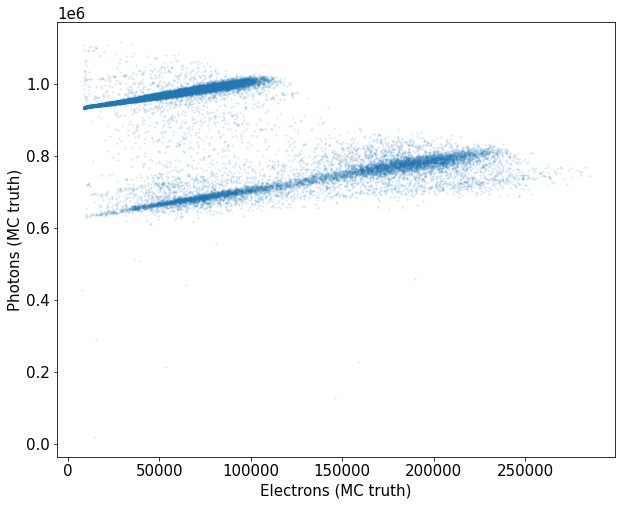

In [4]:
x_charge = np.linspace(0,150000,20)
plt.scatter(df['MCElectrons'],df['MCPhotons'],s=2,alpha=0.1)
plt.xlabel('Electrons (MC truth)')
plt.ylabel('Photons (MC truth)')

In [5]:
bipo_only = (DriftTime>0) & (df['MCPhotons']>800000+0.9*df['MCElectrons'])
df = df[bipo_only & df['IsFull3D'].astype(bool)]
DriftTime = DriftTime[bipo_only & df['IsFull3D'].astype(bool)]

In [6]:
for k in df.keys():
    print(k)

ChannelPositions
ChannelTypes
Cluster Drift Time
Cluster Energies
Cluster X-Pos
Cluster Y-Pos
Cluster Z-Pos
Event
File
IsFull3D
MCElectrons
MCPhotons
NoiseIndex
NumSiPMChannelsHit
NumTileChannelsHit
NumXTileChannelsHit
NumYTileChannelsHit
Number3DClusters
NumberOfClusters
SiPM 1-1 Baseline
SiPM 1-1 Baseline RMS
SiPM 1-1 Induced Charge
SiPM 1-1 Pulse Area
SiPM 1-1 Pulse Height
SiPM 1-1 Pulse Time
SiPM 1-1 T10
SiPM 1-1 T20
SiPM 1-1 T5
SiPM 1-1 T80
SiPM 1-1 T90
SiPM 1-2 Baseline
SiPM 1-2 Baseline RMS
SiPM 1-2 Induced Charge
SiPM 1-2 Pulse Area
SiPM 1-2 Pulse Height
SiPM 1-2 Pulse Time
SiPM 1-2 T10
SiPM 1-2 T20
SiPM 1-2 T5
SiPM 1-2 T80
SiPM 1-2 T90
SiPM 1-3 Baseline
SiPM 1-3 Baseline RMS
SiPM 1-3 Induced Charge
SiPM 1-3 Pulse Area
SiPM 1-3 Pulse Height
SiPM 1-3 Pulse Time
SiPM 1-3 T10
SiPM 1-3 T20
SiPM 1-3 T5
SiPM 1-3 T80
SiPM 1-3 T90
SiPM 1-4 Baseline
SiPM 1-4 Baseline RMS
SiPM 1-4 Induced Charge
SiPM 1-4 Pulse Area
SiPM 1-4 Pulse Height
SiPM 1-4 Pulse Time
SiPM 1-4 T10
SiPM 1-4 T20
SiPM 

(0.0, 80.0)

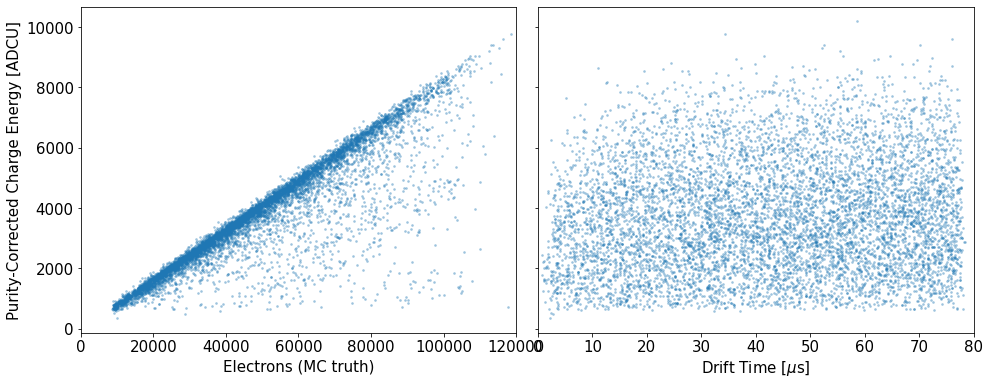

In [7]:
#plt.scatter(df['WeightedPosX'][df['Purity-Corrected Charge Energy']<1000],df['WeightedPosY'][df['Purity-Corrected Charge Energy']<1000])
#plt.hist(df['Purity-Corrected Charge Energy'][df['Number3DClusters']==1],bins=50,histtype='step',log=True)
fig, ax = plt.subplots(1,2,figsize=(16,6),sharey=True,gridspec_kw={'wspace':0.05})
ax[0].scatter(df['MCElectrons'],df['Purity-Corrected Charge Energy'],s=3,alpha=0.3)
ax[0].set_xlim(0,120000)
ax[0].set_xlabel('Electrons (MC truth)')
ax[0].set_ylabel('Purity-Corrected Charge Energy [ADCU]')
ax[1].scatter(DriftTime,df['Purity-Corrected Charge Energy'],s=3,alpha=0.3)
ax[1].set_xlabel('Drift Time [$\mu$s]')
ax[1].set_xlim(0,80)
#plt.xlim(-45,45)
#plt.ylim(0,2000)

In [8]:
sc_list = analysis_config.channel_map['ChannelName'][(analysis_config.channel_map['NumDevicesInChannel'] > 2) & (analysis_config.channel_map['ChannelType'] == 'TileStrip')]
mask_sc = np.ones(len(df)).astype(bool)
for ch_name in sc_list:
    mask_sc = np.logical_and((df['TileStrip %s Charge Energy'%ch_name]<2*df['TileStrip %s Baseline RMS'%ch_name]),mask_sc)
print(sc_list)

10    Y1-10
25    X1-12
Name: ChannelName, dtype: object


In [9]:
keys = df.keys()
relative_energy_SS = np.zeros(sum(mask_sc))
for i,ix in enumerate(df[mask_sc].index):
    mx = 0
    for k in keys:
        if ('Charge Energy' in k) and ('TileStrip' in k) and (df[k][ix]>mx):
            mx = df[k][ix]
    relative_energy_SS[i] = mx/df['TotalTileEnergy'][ix]

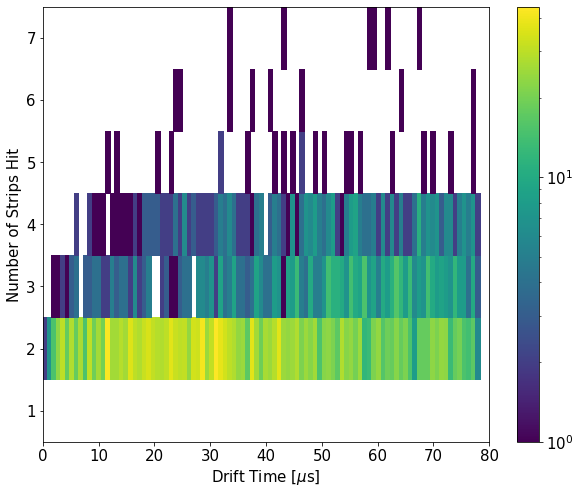

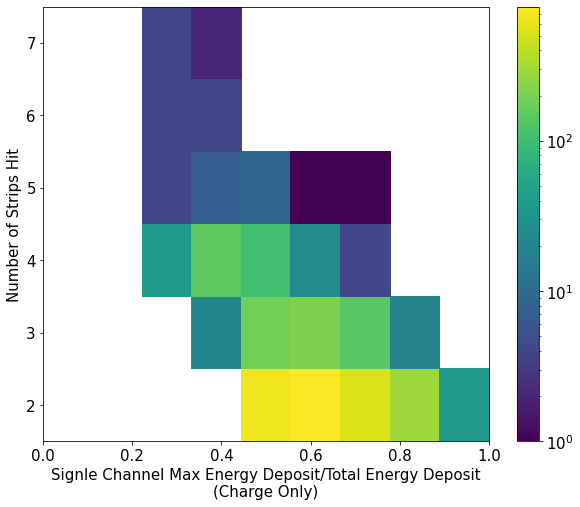

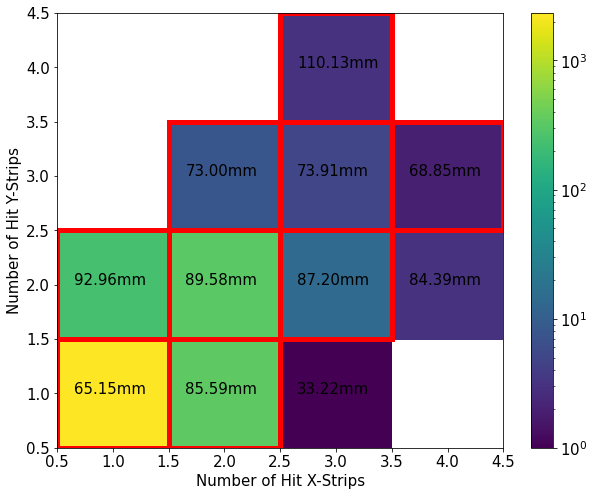

In [10]:
import matplotlib.colors as colors
plot1 = mask_sc
xlim = int(max(df['NumberOfClusters'][plot1]))
#plt.hist2d(df['NumberOfClusters'][plot1],\
#           relative_energy[plot1],bins=[np.linspace(0,xlim,xlim+1)+0.5,np.linspace(0,1,50)],norm=colors.LogNorm())
#plt.colorbar()
#plt.xlabel('Number Of Clusters')
#plt.ylabel('Highest Energy Cluster/Total Energy Deposit\n(Charge Energy)')
#plt.show()
plot3 = mask_sc
plot2 = mask_sc
xlim = int(max(df['NumTileChannelsHit'][plot2]))
plt.hist2d(DriftTime[plot3][(relative_energy_SS>0) & (relative_energy_SS<1)],\
           df['NumTileChannelsHit'][plot3][(relative_energy_SS>0) & (relative_energy_SS<1)],bins=[np.linspace(0,80,100),np.linspace(0,xlim,xlim+1)+0.5],\
           norm=colors.LogNorm())
#plt.ylim(1.5,5.5)
plt.colorbar()
plt.xlabel('Drift Time [$\mu$s]')
plt.ylabel('Number of Strips Hit')
plt.show()
#plt.hist(relative_energy_SS[(relative_energy_SS>0) & (relative_energy_SS<1)],bins=30,log=True)
#plt.xlabel('Signle Channel Max Energy Deposit/Total Energy Deposit\n(Charge Only)')
#plt.show()
plt.hist2d(relative_energy_SS[(relative_energy_SS>0) & (relative_energy_SS<1)],\
           df['NumTileChannelsHit'][mask_sc][(relative_energy_SS>0) & (relative_energy_SS<1)],\
           bins=[np.linspace(0,1,10),[1.5,2.5,3.5,4.5,5.5,6.5,7.5]],
           norm=colors.LogNorm())
plt.xlabel('Signle Channel Max Energy Deposit/Total Energy Deposit\n(Charge Only)')
plt.ylabel('Number of Strips Hit')
plt.colorbar()
plt.show()
xlim = int(max(df['NumXTileChannelsHit'][plot3]))
ylim = int(max(df['NumYTileChannelsHit'][plot3]))
xlim = 4
ylim = 4
plt.hist2d(df['NumXTileChannelsHit'][plot3],\
           df['NumYTileChannelsHit'][plot3],bins=[np.linspace(-1,xlim,xlim+2)+0.5,np.linspace(-1,ylim,ylim+2)+0.5],\
           norm=colors.LogNorm())
plt.xlim(0.5,4.5)
plt.ylim(0.5,4.5)
plt.colorbar()
plt.xlabel('Number of Hit X-Strips')
plt.ylabel('Number of Hit Y-Strips')
for x,y in itertools.product(range(xlim+1),range(ylim+1)):
    msk = (df['NumXTileChannelsHit'] == x) & (df['NumYTileChannelsHit'] == y) & plot3
    val = '{:.2f}'.format(np.mean(DriftTime[msk]*analysis_config.run_parameters['Drift Velocity [mm/us]']))
    if val != 'nan':
        plt.text(x-0.35,y,val+'mm')
        if abs(x-y)<2:
            plt.gca().add_patch(Rectangle((x-0.5, y-0.5), 1, 1, fill=False, ec='red', lw=5))
plt.show()

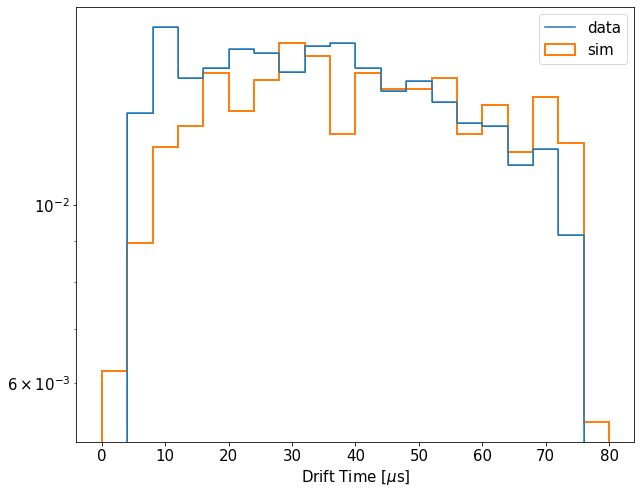

In [11]:
%store -r h_bipo_data
plt.step(h_bipo_data[1][1:],h_bipo_data[0],label='data')
plt.hist(DriftTime[mask_sc],bins=20,histtype='step',range=(0,80),density=True,label='sim',lw=2)
plt.xlabel('Drift Time [$\mu$s]')
plt.legend()
plt.yscale('log')

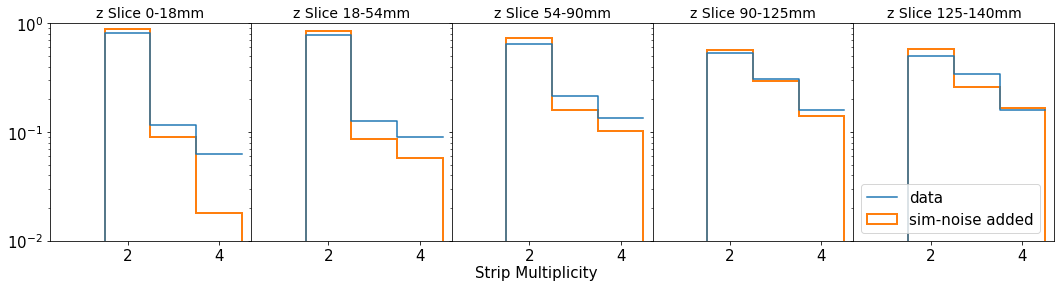

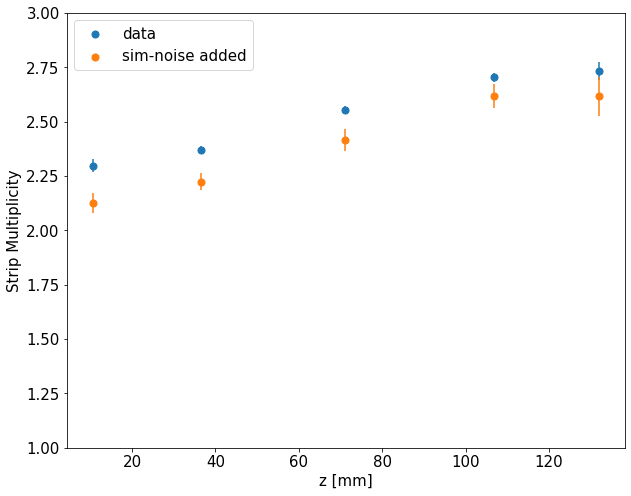

In [12]:
%store -r hist_export_bipo
%store -r val_export_bipo
%store -r err_export_bipo
%store -r z_err_export_bipo
min_time = 10
max_time = 70
time_slice_number = 4
drift_velocity = analysis_config.run_parameters['Drift Velocity [mm/us]']
z_slice = np.linspace(min_time,max_time,time_slice_number)*drift_velocity
fig1,ax1 = plt.subplots(1,time_slice_number+1,sharey=True,gridspec_kw={'wspace': 0,'hspace': 0})
ax1[0].set_ylim(0.01,1)
z_bin_phys = np.digitize(DriftTime[plot3],z_slice)
z_bin_phys_sc = np.digitize(DriftTime[plot3][mask_sc],z_slice/drift_velocity)
fig1.set_size_inches(18,4)
ax1[0].set_yscale('log')
fig2 = plt.figure(2)
#fig2.set_size_inches(6,5)
for ds in range(time_slice_number+1):
    if ds == 0:
        title1 = 0
        title2 = z_slice[ds]
    elif ds == time_slice_number:
        title1 = z_slice[ds-1]
        title2 = 140
    else:
        title1 = z_slice[ds-1]
        title2 = z_slice[ds]
    plt.figure(fig1.number)
    ax1[ds].set_title('z Slice {:.0f}-{:.0f}mm'.format(title1,title2), fontsize=14)
    if ds == time_slice_number:
        ax1[ds].step(hist_export_bipo[ds][1][1:],hist_export_bipo[ds][0],label='data')
        ax1[ds].hist(df['NumTileChannelsHit'][plot3][mask_sc][z_bin_phys_sc==ds],\
                     bins=[0.5,1.5,2.5,3.5,4.5],label='sim-noise added',histtype='step',density=True,lw=2)
        plt.legend()
    else:
        ax1[ds].step(hist_export_bipo[ds][1][1:],hist_export_bipo[ds][0])
        ax1[ds].hist(df['NumTileChannelsHit'][plot3][mask_sc][z_bin_phys_sc==ds],\
                     bins=[0.5,1.5,2.5,3.5,4.5],histtype='step',density=True,lw=2)
    #mean = np.mean(df['NumTileChannelsHit'][plot3][z_bin_phys==ds])
    #std = np.std(df['NumTileChannelsHit'][plot3][z_bin_phys==ds])
    #z_mean = np.mean(DriftTime[plot3][z_bin_phys==ds])
    #z_std = np.std(DriftTime[plot3][z_bin_phys==ds])
    mean_sc = np.mean(df['NumTileChannelsHit'][plot3][mask_sc][z_bin_phys_sc==ds])
    std_sc = np.std(df['NumTileChannelsHit'][plot3][mask_sc][z_bin_phys_sc==ds])/np.sqrt(sum(z_bin_phys_sc==ds))
    z_mean_sc = np.mean(DriftTime[plot3][mask_sc][z_bin_phys_sc==ds])
    z_std_sc = np.std(DriftTime[plot3][mask_sc][z_bin_phys_sc==ds])/np.sqrt(sum(z_bin_phys_sc==ds))
    plt.figure(fig2.number)
    if ds == time_slice_number:
        plt.scatter(z_mean_sc*drift_velocity,val_export_bipo[ds],s=50,label='data',c='C0')
        plt.errorbar(z_mean_sc*drift_velocity,val_export_bipo[ds],\
                     2*err_export_bipo[ds],z_err_export_bipo[ds]*drift_velocity,c='C0')
        plt.scatter(z_mean_sc*drift_velocity,mean_sc,s=50,label='sim-noise added',c='C1')
        plt.errorbar(z_mean_sc*drift_velocity,mean_sc,2*std_sc,z_std_sc,c='C1')
        plt.legend(loc=2)
    else:
        plt.scatter(z_mean_sc*drift_velocity,val_export_bipo[ds],s=50,c='C0')
        plt.errorbar(z_mean_sc*drift_velocity,val_export_bipo[ds],\
                     2*err_export_bipo[ds],z_err_export_bipo[ds]*drift_velocity,c='C0')
        plt.scatter(z_mean_sc*drift_velocity,mean_sc,s=50,c='C1')
        plt.errorbar(z_mean_sc*drift_velocity,mean_sc,2*std_sc,z_std_sc,c='C1')
plt.xlabel('z [mm]')
plt.ylabel('Strip Multiplicity')
plt.ylim(1,3)
fig1.text(0.5, 0, 'Strip Multiplicity', ha='center')
plt.show()

Text(0.5, 0, 'Purity-Corrected Charge Energy [ADCU]')

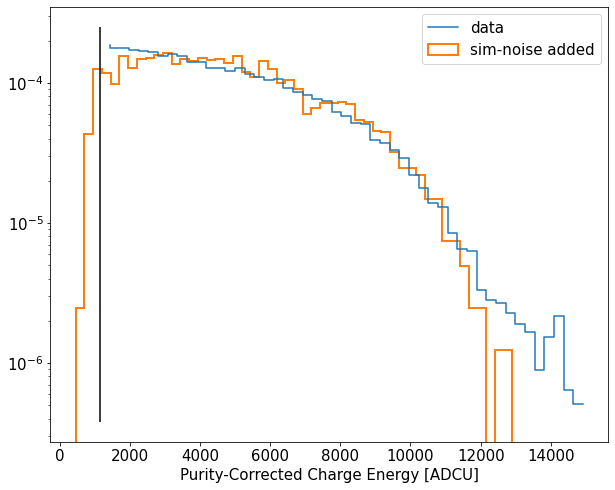

In [17]:
%store -r h
%store -r bn
plt.step(bn[1:],h,label='data')
plt.hist(df['Purity-Corrected Charge Energy'][mask_sc]*1.32,bins=50,histtype='step',\
         log=True,density=True,label='sim-noise added',lw=2)
plt.vlines(1150,plt.gca().get_ylim()[0],plt.gca().get_ylim()[1])
plt.legend()
plt.xlabel('Purity-Corrected Charge Energy [ADCU]')

In [16]:
mask = df['Purity-Corrected Charge Energy']<900

/g/g90/jacopod/uproot/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Finished loading.
853.3212778638788 51.968


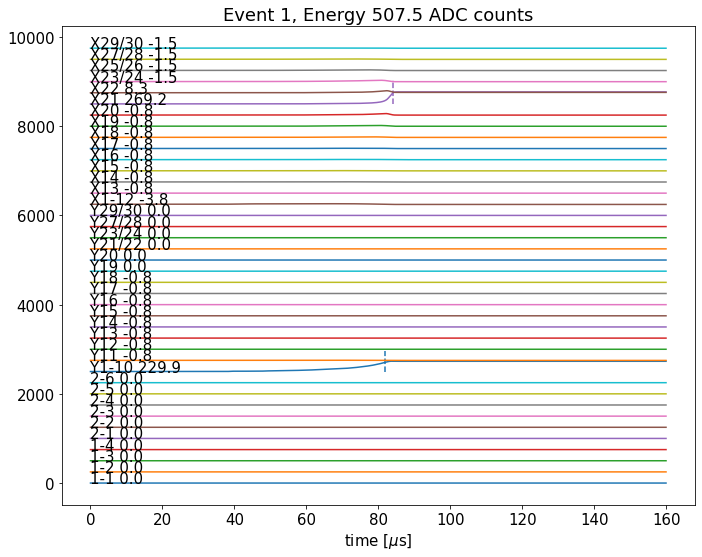

/g/g90/jacopod/uproot/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Finished loading.
399.2677164738909 48.512


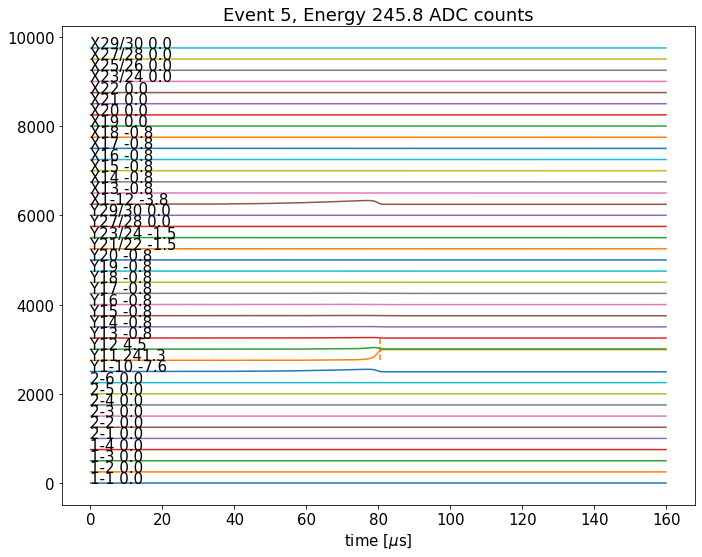

/g/g90/jacopod/uproot/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Finished loading.
623.7463461727249 53.504


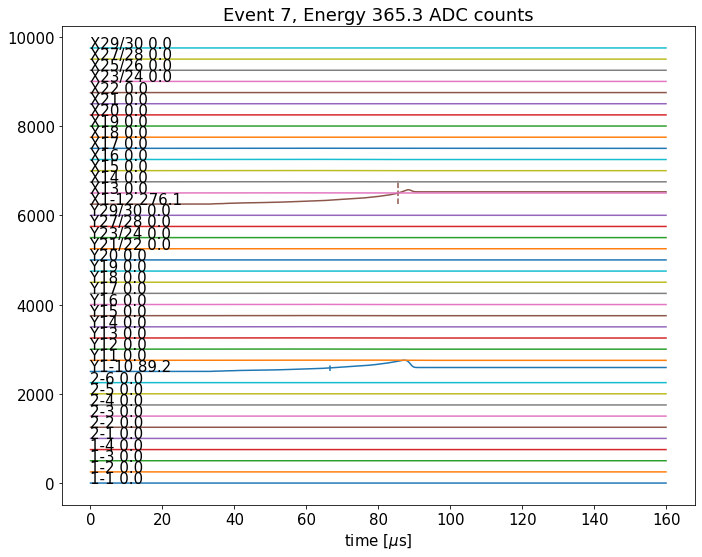

/g/g90/jacopod/uproot/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Finished loading.
783.8833569290707 10.624


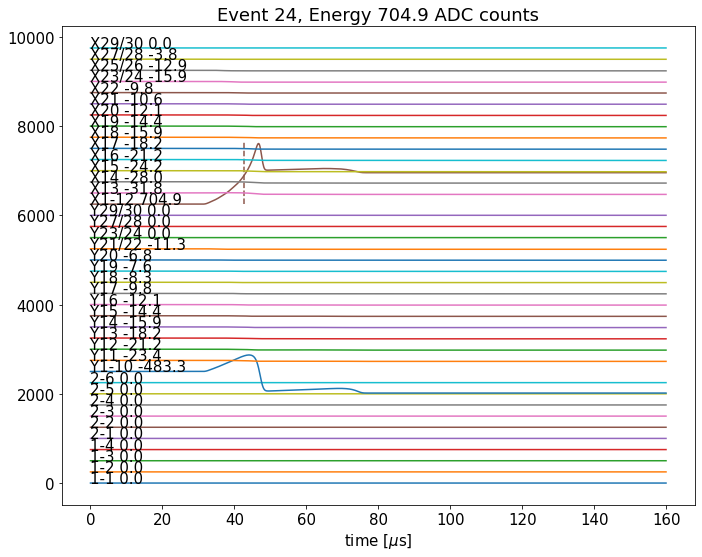

/g/g90/jacopod/uproot/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Finished loading.
606.1652033508202 7.04


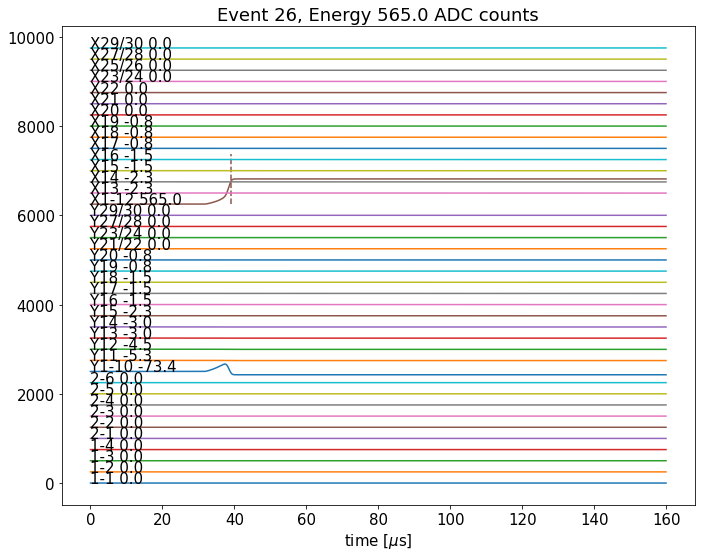

/g/g90/jacopod/uproot/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Finished loading.
750.6494765331576 52.864000000000004


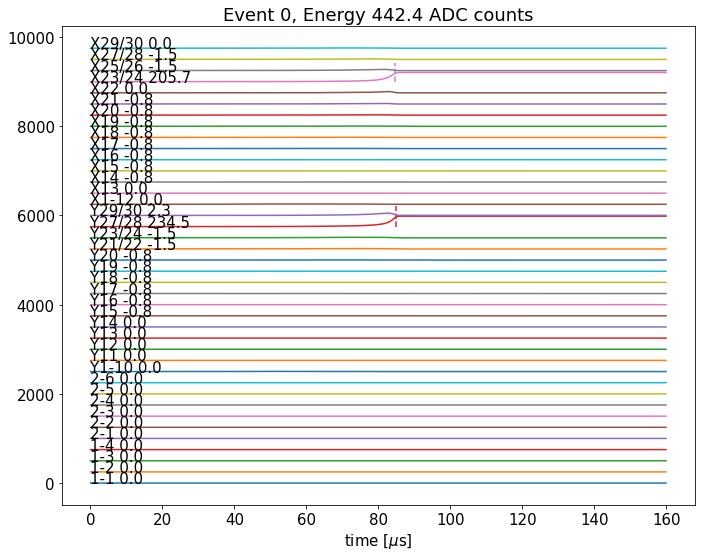

/g/g90/jacopod/uproot/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Finished loading.
235.51164241048156 0.128


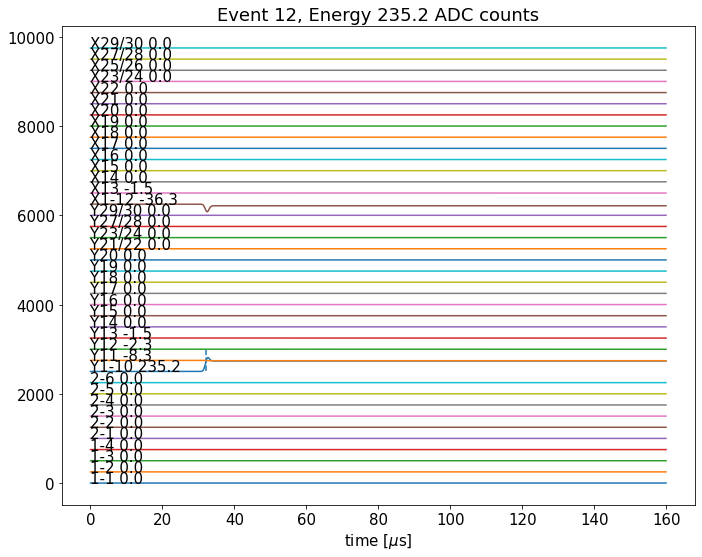

/g/g90/jacopod/uproot/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Finished loading.
795.5031972106757 74.368


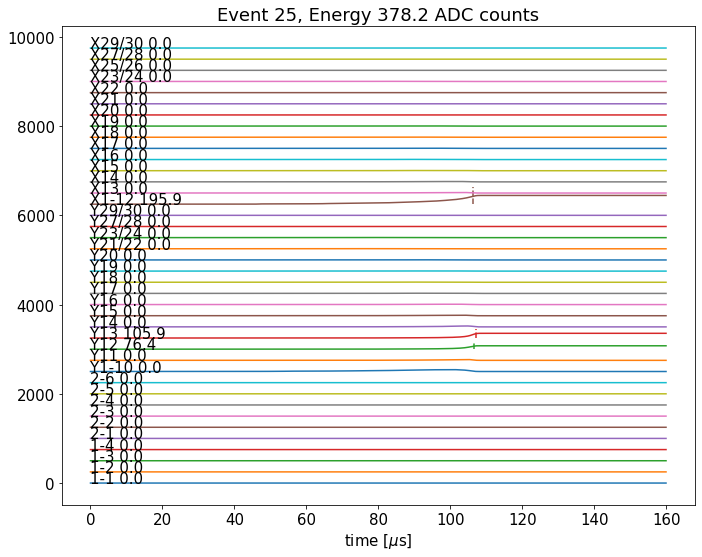

/g/g90/jacopod/uproot/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Finished loading.
746.212959239909 20.224


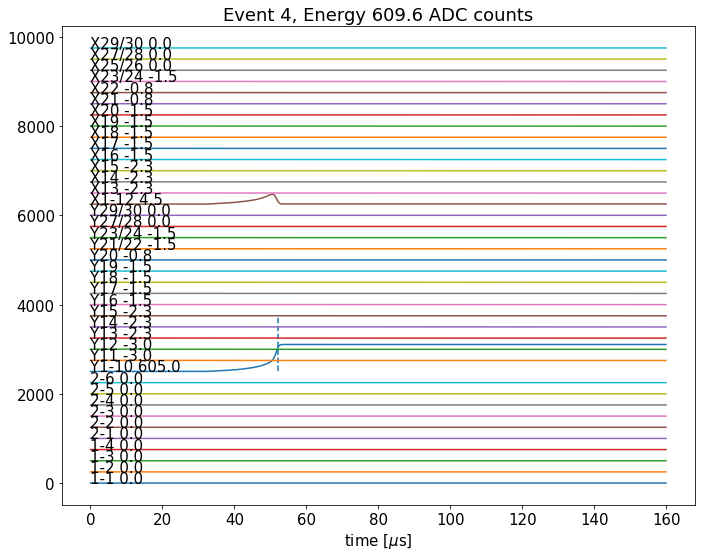

/g/g90/jacopod/uproot/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Finished loading.
702.8601889287022 1.6640000000000001


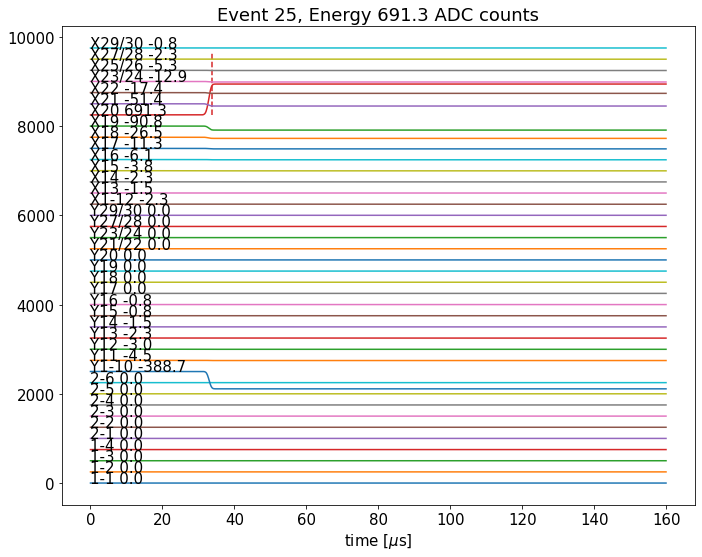

In [17]:
run_parameters_file = '/g/g90/jacopod/software/TMSAnalysis/config/30th/Run_Parameters_Run30.xlsx'
calibrations_file = '/g/g90/jacopod/software/TMSAnalysis/config/30th/Calibrations_Xe_Run30.csv'
channel_map_file = '/g/g90/jacopod/software/TMSAnalysis/config/30th/Channel_Map_Run30.xlsx'
for i in df[mask].index[:10]:
    event = Waveform.Simulated_Event('/p/lustre1/jacopod/30th/20210502_bipo_sim/no_noise_500ns/reduced_added.p',\
                                     '/p/lustre1/lenardo1/stanford_teststand/simulations/May2_2021_BiPoSims',\
                                     i,\
                                     run_parameters_file,\
                                     calibrations_file,\
                                     channel_map_file,\
                                     add_noise=False)

#    event1 = Waveform.Simulated_Event('/p/lustre1/jacopod/30th/20210502_bipo_sim/with_noise_500ns/reduced_added.p',\
#                                     '/p/lustre1/lenardo1/stanford_teststand/simulations/May2_2021_BiPoSims',\
#                                     i,\
#                                     run_parameters_file,\
#                                     calibrations_file,\
#                                     channel_map_file,\
#                                     add_noise=True)
    event.smooth(0.5)
#    #plot.show()
#    plt.figure(figsize=(20,10))
#    plt.subplot(121)
    event.plot_event(True)
    print(df['Purity-Corrected Charge Energy'].loc[i],DriftTime.loc[i])
#    plt.subplot(122)
#    event1.plot_event(True)
    plt.show()